In [1]:
import torch.cuda
import sys

sys.path.append('..')
SEED=1

from src.henry.mnist_vae_pure import VariationalAutoencoder
import torchvision
import torchvision.datasets as datasets
import pickle
from matplotlib import pyplot as plt
import numpy as np
from utils import * 
from WeightsModification import * 
from federated_pure import federate




In [2]:
class FakeArgs:
    def __init__(self):
        self.seed=4237987
        self.epochs = 10
        self.dataset = "mnist"
        self.num_users=4
        self.iid = 3
        self.dirichlet = 0.5 
        self.local_ep=10
        self.local_bs=64
        self.beta=1.0
        self.frac_split=0.5
    # def __init__(self):
    #     self.seed=SEED
    #     self.epochs = 25
    #     self.dataset = "fmnist"
    #     self.num_users=10
    #     self.iid = 2
    #     self.dirichlet = 0.5 
    #     self.local_ep=10
    #     self.local_bs=64
    #     self.beta=1.0
        

In [15]:
alpha_values = [0.1,0.5,1.0,2.0]
vae_beta_values = [1.0,5.0,10.0]

for vae_beta_val in vae_beta_values:
    runtime_args = FakeArgs()
    runtime_args.beta=vae_beta_val
    
    baseline_result = federate(runtime_args)
    baseline_result.serialise("baseline", runtime_args)
    
    for alpha in alpha_values:
        new_weights = calculate_new_weights(baseline_result.global_model.encoder, baseline_result.client_datasets, alpha,0.0)

        second_res = federate(runtime_args,new_weights, baseline_result.client_datasets)
        second_res.serialise("alpha_" + str(alpha),runtime_args)
        
    
    
    
    
    





/home/henry/anaconda3/envs/rp/lib/python3.12/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
0it [00:00, ?it/s]


TRAINING ALL DONE!


KeyboardInterrupt: 

In [3]:
# vae, ovr_losses, mse_losses, kl_losses = vae.train_model(dataset_train,16,10)
# print(mse_losses)
# print(kl_losses)
# 46 -> 34
res = federate(FakeArgs())
res.serialise("BOGUS_TEST",FakeArgs())





/home/henry/anaconda3/envs/rp/lib/python3.12/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
  0%|          | 0/10 [00:00<?, ?it/s]


 | Global Training Round : 1 |

Training user 0 in round 1
Finished local epoch 1 out of 10, average loss across batches: 602.9863385139628
Finished local epoch 2 out of 10, average loss across batches: 559.4985645050698
Finished local epoch 3 out of 10, average loss across batches: 550.180893139129
Finished local epoch 4 out of 10, average loss across batches: 545.2921407496675
Finished local epoch 5 out of 10, average loss across batches: 541.8073885004571
Finished local epoch 6 out of 10, average loss across batches: 539.5122345620014
Finished local epoch 7 out of 10, average loss across batches: 537.8460931006898
Finished local epoch 8 out of 10, average loss across batches: 536.3782021380486
Finished local epoch 9 out of 10, average loss across batches: 535.0337334815492
Finished local epoch 10 out of 10, average loss across batches: 533.3948304521276
Training user 1 in round 1
Finished local epoch 1 out of 10, average loss across batches: 594.215989392869
Finished local epoch 2 

 10%|█         | 1/10 [01:36<14:31, 96.80s/it]

TEST LOSS AT GLOBAL ROUND 1 totalL: 644.2698196777344

 | Global Training Round : 2 |

Training user 0 in round 2
Finished local epoch 1 out of 10, average loss across batches: 546.0226987148853
Finished local epoch 2 out of 10, average loss across batches: 530.7368047186669
Finished local epoch 3 out of 10, average loss across batches: 526.9870576899102
Finished local epoch 4 out of 10, average loss across batches: 524.4914719601895
Finished local epoch 5 out of 10, average loss across batches: 522.4995634038397
Finished local epoch 6 out of 10, average loss across batches: 520.5854203893783
Finished local epoch 7 out of 10, average loss across batches: 519.823358414021
Finished local epoch 8 out of 10, average loss across batches: 518.1956171563331
Finished local epoch 9 out of 10, average loss across batches: 517.4541340280086
Finished local epoch 10 out of 10, average loss across batches: 516.787128204995
Training user 1 in round 2
Finished local epoch 1 out of 10, average loss acr

 20%|██        | 2/10 [03:08<12:29, 93.68s/it]

TEST LOSS AT GLOBAL ROUND 2 totalL: 548.6690906524658

 | Global Training Round : 3 |

Training user 0 in round 3
Finished local epoch 1 out of 10, average loss across batches: 521.239535717254
Finished local epoch 2 out of 10, average loss across batches: 516.0522988177361
Finished local epoch 3 out of 10, average loss across batches: 513.7901595744681
Finished local epoch 4 out of 10, average loss across batches: 512.4190043997257
Finished local epoch 5 out of 10, average loss across batches: 511.0862790371509
Finished local epoch 6 out of 10, average loss across batches: 510.2740616169382
Finished local epoch 7 out of 10, average loss across batches: 509.67458548038564
Finished local epoch 8 out of 10, average loss across batches: 509.0019372818318
Finished local epoch 9 out of 10, average loss across batches: 507.6564067434757
Finished local epoch 10 out of 10, average loss across batches: 507.4381546345163
Training user 1 in round 3
Finished local epoch 1 out of 10, average loss a

 30%|███       | 3/10 [04:39<10:48, 92.59s/it]

TEST LOSS AT GLOBAL ROUND 3 totalL: 520.7849924484253

 | Global Training Round : 4 |

Training user 0 in round 4
Finished local epoch 1 out of 10, average loss across batches: 510.8073740857713
Finished local epoch 2 out of 10, average loss across batches: 507.7769539041722
Finished local epoch 3 out of 10, average loss across batches: 506.38096508269615
Finished local epoch 4 out of 10, average loss across batches: 505.9467203343168
Finished local epoch 5 out of 10, average loss across batches: 505.7051692881483
Finished local epoch 6 out of 10, average loss across batches: 504.9602659834192
Finished local epoch 7 out of 10, average loss across batches: 504.24322795462103
Finished local epoch 8 out of 10, average loss across batches: 504.079417127244
Finished local epoch 9 out of 10, average loss across batches: 503.52627485559344
Finished local epoch 10 out of 10, average loss across batches: 503.23359167220747
Training user 1 in round 4
Finished local epoch 1 out of 10, average los

 40%|████      | 4/10 [06:12<09:16, 92.82s/it]

TEST LOSS AT GLOBAL ROUND 4 totalL: 512.3407841445922

 | Global Training Round : 5 |

Training user 0 in round 5
Finished local epoch 1 out of 10, average loss across batches: 505.79486006067157
Finished local epoch 2 out of 10, average loss across batches: 504.31311242935504
Finished local epoch 3 out of 10, average loss across batches: 503.1950582301363
Finished local epoch 4 out of 10, average loss across batches: 502.605893268991
Finished local epoch 5 out of 10, average loss across batches: 502.1882125529837
Finished local epoch 6 out of 10, average loss across batches: 501.5229966183926
Finished local epoch 7 out of 10, average loss across batches: 501.15953862616357
Finished local epoch 8 out of 10, average loss across batches: 501.0807567839927
Finished local epoch 9 out of 10, average loss across batches: 500.43857512778425
Finished local epoch 10 out of 10, average loss across batches: 500.04865398001164
Training user 1 in round 5
Finished local epoch 1 out of 10, average lo

 50%|█████     | 5/10 [07:52<07:56, 95.21s/it]

TEST LOSS AT GLOBAL ROUND 5 totalL: 508.40311206970216

 | Global Training Round : 6 |

Training user 0 in round 6
Finished local epoch 1 out of 10, average loss across batches: 502.7263379685422
Finished local epoch 2 out of 10, average loss across batches: 501.22321115047373
Finished local epoch 3 out of 10, average loss across batches: 500.63120389897773
Finished local epoch 4 out of 10, average loss across batches: 500.41452623732545
Finished local epoch 5 out of 10, average loss across batches: 500.62145255880154
Finished local epoch 6 out of 10, average loss across batches: 499.52223887342086
Finished local epoch 7 out of 10, average loss across batches: 499.04902213887965
Finished local epoch 8 out of 10, average loss across batches: 498.7768036537982
Finished local epoch 9 out of 10, average loss across batches: 498.4002298558012
Finished local epoch 10 out of 10, average loss across batches: 498.086023858253
Training user 1 in round 6
Finished local epoch 1 out of 10, average 

 60%|██████    | 6/10 [09:33<06:29, 97.30s/it]

TEST LOSS AT GLOBAL ROUND 6 totalL: 505.54080164642335

 | Global Training Round : 7 |

Training user 0 in round 7
Finished local epoch 1 out of 10, average loss across batches: 500.6876262258976
Finished local epoch 2 out of 10, average loss across batches: 499.6476176809757
Finished local epoch 3 out of 10, average loss across batches: 498.7477280637051
Finished local epoch 4 out of 10, average loss across batches: 498.1512661548371
Finished local epoch 5 out of 10, average loss across batches: 498.0579297654172
Finished local epoch 6 out of 10, average loss across batches: 497.7988760440908
Finished local epoch 7 out of 10, average loss across batches: 497.59491395341587
Finished local epoch 8 out of 10, average loss across batches: 497.3630111369681
Finished local epoch 9 out of 10, average loss across batches: 496.675086358253
Finished local epoch 10 out of 10, average loss across batches: 496.2076595225233
Training user 1 in round 7
Finished local epoch 1 out of 10, average loss 

 70%|███████   | 7/10 [11:16<04:57, 99.06s/it]

TEST LOSS AT GLOBAL ROUND 7 totalL: 504.6509317840576

 | Global Training Round : 8 |

Training user 0 in round 8
Finished local epoch 1 out of 10, average loss across batches: 499.3828186035156
Finished local epoch 2 out of 10, average loss across batches: 497.87893533909573
Finished local epoch 3 out of 10, average loss across batches: 497.4903103442902
Finished local epoch 4 out of 10, average loss across batches: 496.880296033494
Finished local epoch 5 out of 10, average loss across batches: 496.6341955306682
Finished local epoch 6 out of 10, average loss across batches: 496.1322800656582
Finished local epoch 7 out of 10, average loss across batches: 496.89332496156084
Finished local epoch 8 out of 10, average loss across batches: 496.20621779421543
Finished local epoch 9 out of 10, average loss across batches: 495.57628316676363
Finished local epoch 10 out of 10, average loss across batches: 495.76286335397276
Training user 1 in round 8
Finished local epoch 1 out of 10, average lo

 80%|████████  | 8/10 [12:56<03:18, 99.34s/it]

TEST LOSS AT GLOBAL ROUND 8 totalL: 502.74280419006345

 | Global Training Round : 9 |

Training user 0 in round 9
Finished local epoch 1 out of 10, average loss across batches: 497.42659236826796
Finished local epoch 2 out of 10, average loss across batches: 496.6466879986702
Finished local epoch 3 out of 10, average loss across batches: 496.23497353411733
Finished local epoch 4 out of 10, average loss across batches: 496.6090534616024
Finished local epoch 5 out of 10, average loss across batches: 495.932173968376
Finished local epoch 6 out of 10, average loss across batches: 495.47411083464925
Finished local epoch 7 out of 10, average loss across batches: 495.3647024601064
Finished local epoch 8 out of 10, average loss across batches: 494.5083406488946
Finished local epoch 9 out of 10, average loss across batches: 494.295030829247
Finished local epoch 10 out of 10, average loss across batches: 493.9797368475731
Training user 1 in round 9
Finished local epoch 1 out of 10, average loss

 90%|█████████ | 9/10 [14:33<01:38, 98.82s/it]

TEST LOSS AT GLOBAL ROUND 9 totalL: 501.75038607177737

 | Global Training Round : 10 |

Training user 0 in round 10
Finished local epoch 1 out of 10, average loss across batches: 496.3808005474983
Finished local epoch 2 out of 10, average loss across batches: 495.66509581220913
Finished local epoch 3 out of 10, average loss across batches: 494.9461414093667
Finished local epoch 4 out of 10, average loss across batches: 494.4186406561669
Finished local epoch 5 out of 10, average loss across batches: 494.99949834296046
Finished local epoch 6 out of 10, average loss across batches: 494.6936002690741
Finished local epoch 7 out of 10, average loss across batches: 494.1240477217005
Finished local epoch 8 out of 10, average loss across batches: 493.70659400452956
Finished local epoch 9 out of 10, average loss across batches: 493.64997961166057
Finished local epoch 10 out of 10, average loss across batches: 493.2819191790642
Training user 1 in round 10
Finished local epoch 1 out of 10, averag

100%|██████████| 10/10 [16:04<00:00, 96.50s/it]

TEST LOSS AT GLOBAL ROUND 10 totalL: 500.52906510772704
TRAINING ALL DONE!


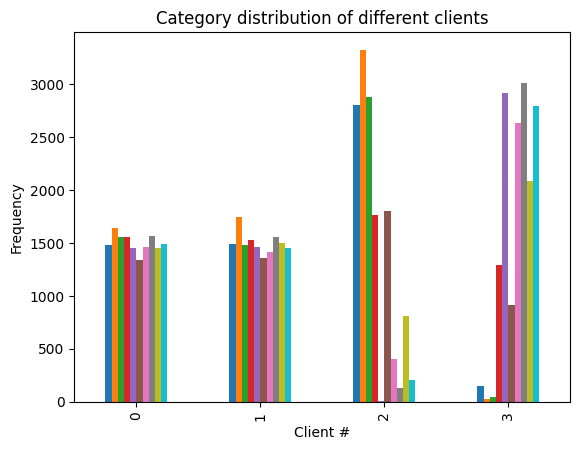

In [4]:
ClientDatasetManager.plot_dataset_splits(res.client_datasets)


In [ ]:
res.global_model = res.global_model.to('cuda')

In [ ]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to('cuda')
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

In [ ]:
plot_reconstructed(res.global_model, r0=(-3, 3), r1=(-3, 3))


In [ ]:
trial_weights = calculate_new_weights(res.global_model.encoder, res.client_datasets, 0.5,0.0)


In [ ]:
print(f"Original Weights: {calculate_relative_dataset_sizes(res.client_datasets)}")
print(f"New Weights: {trial_weights}")

In [ ]:
second_res = federate(FakeArgs(), trial_weights, res.client_datasets)
second_res.serialise("bogus_point_one",FakeArgs())


In [ ]:
a = res.global_loss_manager.validation_total_across_communication

In [ ]:
b = second_res.global_loss_manager.validation_total_across_communication

In [ ]:
list(zip(a,b))